# Neural Language Model - RNN (Recurrent Neural Network)

RNN-based architectures (including, LSTM, GRU, Encoder-Decoder, or Transformer) is widely used in today's NLP.

Recall that language model created in [previous language model example](./05_language_model_basic.ipynb) won't care the long past context.<br>
For example, when the following sentence is given, 

"In the United States, the president has now been"

it won't care the context "In the United States" when it refers only the last 5 words.<br>
There might then be inconsistency in the sentence between former part and latter part.

Let me assume another sentence "it's vulgar and mean, but I liked it.".<br>
This sentence includes some negative phrases ("vulgar", "mean"), but the overall sentence has positive sentiment. This example shows that it's needed for precise predictions to understand not only individual phrases, but also the context in which they occur.

In recurrent architecture, past context (called states) is inherited to the next prediction by the state memory $ s $ (which is trained by input and previous state), and this connection continues in the chain as follows. (See the following diagram.)<br>
In this network, the next state $s_{i+1}$ is predicted by input $x_i$ and previous state $s_i$ in the network $R$ (which is called a recurrent unit) and this will be connected from beginning to the end of sequence. The output $y$ in each recurrent unit is generated by the state $s$ and the function $f(\cdot)$. The output $y$ is then used for prediction in each unit.

> Note : In simple RNN and GRU, $ f(\cdot) $ in the following diagram is identity function.

Recurrent Neural Network (RNN) will then be able to represent arbitrary size of sequence.

![recurrent architecture](images/rnn_architecture.png?raw=true)

There are a lot of variants (including today's state-of-the-art model) in recurrent architecture.

In **bidirectional RNN (BiRNN)**, the states in both directions (forward states and backward states) are maintained and trained as follows.

![bidirectional rnn](images/bidirectional_rnn.png?raw=true)

Imagine that you predict the word [jumped] in the sentence, "the brown fox [xxxxx] over the dog". In this example, the latter context ("over the dog") is also important in the prediction.<br>
The bidirectional RNN (BiRNN) is very effective, also in tagging tasks.

In **deep RNN** (see below), the output is more deeply learned by multi-layered architecture.

![deep rnn](images/deep_rnn.png?raw=true)

One of successful architecture in RNN is recurrent **gated architecture**.<br>
With simple RNN, it will suffer from vanishing gradient problems, with which a lot of layers will rapidly lead the gradients of loss to zeros. (It will then eventually become hard to train the long past context in sequence.)
In brief pictures, gated architecture will avoid this problem by using gate vector $ g $ and new memory $ s^{\prime} $ as follows :

$ s^{\prime} = g \cdot x + (1 - g) \cdot s $

where $ \cdot $ is inner product operation and $1$ is vector $(1,1,\ldots,1)$.

This computation will read the entries of input $ x $ which correspond to 1 values in $ g $, and read the entries of state $ s $ which correspond to 0 values in $ g $.<br>
$ g $ is then also controlled and tarined by input and previous memory state.

**LSTM (Long Short Term Memory)** and **GRU (Gated Recurrent Unit)** are widely used gated architectures in language tasks.<br>
I'll show you GRU in the following diagram.

![gru architecture](images/gru_gate.png?raw=true)

$$ R : r_i = \sigma(W_{rx} x_i + W_{rs} s_{i-1}) $$
$$ Z : z_i = \sigma(W_{zx} x_i + W_{zs} s_{i-1}) $$

$$ \tilde{S} : \tilde{s}_i = tanh(W_{sx} x_i + W_{ss} (r_i \cdot s_{i-1})) $$
$$ S : s_i = (1 - z_i) \cdot s_{i-1} + z_i \cdot \tilde{s}_i $$

where $ \sigma(\cdot) $ is sigmoid activation and $ tanh(\cdot) $ is tanh activation. (See [here](https://tsmatz.wordpress.com/2017/08/30/glm-regression-logistic-poisson-gaussian-gamma-tutorial-with-r/) for sigmoid and tanh operation.)

> Note : The bias term is often included, such as $ Z : z_i = \sigma(W_{zx} x_i + W_{zs} s_{i-1} + b_z) $.

In GRU architecture, the new state candidate $ \tilde{s}_i $ is computed by using the controlled parameter $ r_i $. (And $ r_i $ is also trained by inputs.)<br>
The updated final state $ s_i $ is then determined based on the weight between previous state $ s_{i-1} $ and state candidate $ \tilde{s}_i $, by using controlled parameter $ z_i $. (And $ z_i $ is also trained by inputs.)

In this example, I'll show 2 language models with both simple RNN (Simple Recurrent Neural Network) and GRU (Gated Recurrent Unit) architecture.

> Note : In this example, I'll apply **word-level (word-to-word)** RNN, but you can also use **character-level (character-to-character)** RNN, which can learn unseen words with signals - such as, prefixes (e.g, "un...", "dis..."), suffixes (e.g, "...ed", "...ing"), capitalization, or presence of certain characters (e.g, hyphen, digits), etc.

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

## Install required packages

In [ ]:
!pip install tensorflow==2.6.2 pandas numpy matplotlib

## Prepare data

In this example, I have used short description text in news papers dataset, since it's formal-styled concise sentence (not including slangs and it's today's modern English).<br>
Before starting, please download [News_Category_Dataset_v2.json](https://www.kaggle.com/datasets/rmisra/news-category-dataset) (collected by HuffPost) in Kaggle.

In [2]:
import pandas as pd

df = pd.read_json("News_Category_Dataset_v2.json",lines=True)
train_data = df["short_description"]
train_data

0         She left her husband. He killed their children...
1                                  Of course it has a song.
2         The actor and his longtime girlfriend Anna Ebe...
3         The actor gives Dems an ass-kicking for not fi...
4         The "Dietland" actress said using the bags is ...
                                ...                        
200848    Verizon Wireless and AT&T are already promotin...
200849    Afterward, Azarenka, more effusive with the pr...
200850    Leading up to Super Bowl XLVI, the most talked...
200851    CORRECTION: An earlier version of this story i...
200852    The five-time all-star center tore into his te...
Name: short_description, Length: 200853, dtype: object

To get the better performance (accuracy), we standarize the input text as follows.
- Make all words to lowercase in order to reduce words
- Make "-" (hyphen) to space
- Remove all punctuation except " ' " (e.g, Ken's bag) and "&" (e.g, AT&T)

> Note : To make simplify, I have skipped other pre-processing, such as, N-gram detection (see [this example](./04_ngram_cnn.ipynb)), polysemy processing, etc.

In [3]:
train_data = train_data.str.lower()
train_data = train_data.str.replace("-"," ")
train_data = train_data.str.replace("[^'\&\w\s]","")
train_data = train_data.str.strip()
train_data

0         she left her husband he killed their children ...
1                                   of course it has a song
2         the actor and his longtime girlfriend anna ebe...
3         the actor gives dems an ass kicking for not fi...
4         the dietland actress said using the bags is a ...
                                ...                        
200848    verizon wireless and at&t are already promotin...
200849    afterward azarenka more effusive with the pres...
200850    leading up to super bowl xlvi the most talked ...
200851    correction an earlier version of this story in...
200852    the five time all star center tore into his te...
Name: short_description, Length: 200853, dtype: object

## Generate sequence inputs

We will generate the sequence of word's indices (i.e, tokenize) from text.

![Index vectorize](images/index_vectorize.png?raw=true)

First we build word's vectorizer.

In [4]:
import tensorflow as tf

max_word = 50000

vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=None, # maximum length of sequences
    output_mode="int")
vectorization.adapt(train_data)

#vocab_size = len(vectorization.get_vocabulary())

Now we vectorize all sentence into integer's sequence as follows.<br>
In this example, we create varying size of sequence in each row (not padded by zero).

"foo qux bar" -> ```[2, 1, 3]```<br>
"qux baz" -> ```[1, 4]```

![Index vectorize](images/index_vectorize.png?raw=true)

In [5]:
train_tf_data = tf.data.Dataset.from_tensor_slices(train_data)
def text_to_sequence(x):
    seq = vectorization(x)
    return seq
train_tf_data = train_tf_data.map(lambda x: text_to_sequence(x))
train_tf_data = train_tf_data.filter(lambda x: len(x) > 0)

Now we generate inputs for features (x) and label (y).<br>
In this task, we predict the next word in the sequence, and we then create the following features (batch_x) and label (batch_y) in each row.

<u>train_tf_data (before)</u> :
```
[2, 1, 3]
```

<u>train_tf_data (after)</u> :

batch_x
```
[2, 1, 3]
```

batch_y
```
[1, 3, 0]
```

In [6]:
def sequence_to_train_batch(x):
    #batch_x = tf.slice(x, begin=[0], size=[len(x)])
    batch_x = x
    batch_y = tf.slice(x, begin=[1], size=[len(x) - 1])
    batch_y = tf.concat([batch_y, [0]], axis=0)
    return batch_x, batch_y
train_tf_data = train_tf_data.map(lambda x: sequence_to_train_batch(x))

Now we convert label y into one-hot vector (shape (50000,)).

batch_y (before) :
```
[1, 3, 0]
```

batch_y (after) :
```
[
  [0,1,0,0, ... ,0],
  [0,0,0,1, ... ,0],
  [1,0,0,0, ... ,0]
]
```

In [7]:
def to_one_hot(x, y):
    batch_x = x
    batch_y = tf.one_hot(y, depth=max_word)
    return batch_x, batch_y
train_tf_data = train_tf_data.map(lambda x, y: to_one_hot(x, y))

## Train with Simple RNN

Now we build a model for this next word's prediction using simple RNN architecture.

In TensorFlow, you can use the built-in ```tf.keras.layers.SimpleRNN``` layer for processing simple RNN.

In this built-in layer, the shape of RNN input is expected to be ```(batch_size, sequence_length, input_dimension)```, and by setting ```stateful=True```, the last state at index i in batch is used as initial state for index i in the following batch.

In this example, we'll use input with shape ```(1, sequence_length, input_dimension)``` (i.e, batch size is always 1), because the size of sequence varies in each row in dataset.<br>
Here we then set ```stateful=False```. (Because the sequence in the following batch doesn't depend on the sequence in previous batch.)

> Note : In TensorFlow, you can handle batch inputs with 0-padded sequence (fixed length of input's sequence) by specifying ```mask``` argument. (You don't then necessarily set batch size = 1.) Here I don't use masking for the purpose of your beginning, but use masking to scale the training in production.<br>
> In later examples, I'll use masking to scale.

In [8]:
class SimpleRnnModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size,
            embedding_dim,
            trainable=True,
        )
        self.rnn = tf.keras.layers.SimpleRNN(
            rnn_units,
            return_sequences=True,
            return_state=True,
            stateful=False,  # not to inherit states between batches
            trainable=True,
        )
        self.dense = tf.keras.layers.Dense(
            self.vocab_size,
            activation=None,
        )

    def call(self, inputs, states=None, training=False, return_state=False):
        tensor = self.embedding(inputs, training=training)
        if states is None:
            tensor, new_states = self.rnn(tensor, training=training)
        else:
            tensor, new_states = self.rnn(tensor, initial_state=states, training=training)
        outputs = self.dense(tensor, training=training)

        if return_state:
            return outputs, new_states  # This is used in prediction
        else:
            return outputs              # This is used in training

Now run training with above model.

As I have mentioned above, we use inputs with shape ```(1, sequence_length, input_dimension)```, and we then expand original dimension ```(sequence_length, input_dimension)``` into ```(1, sequence_length, input_dimension)``` by ```tf.expand_dims()```.

> Note : In the following example, I write a training loop from scratch, but you can also build custom model for this implementation.

In [9]:
embedding_dim = 64
rnn_units = 512
n_epoch = 5
shuffle_buffer_size = 1000
train_seq_size = 50  # apply gradient (=train) in each 50 iterations
loss_records = []

model = SimpleRnnModel(
    vocab_size=max_word,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
loss_func = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.SUM
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### I don't use train_tf_data.repeat(n_epoch) and run shuffle in each epoch,
### because I want to check result in each epoch
for epoch in range(n_epoch):
    tf_data_epoch = train_tf_data.shuffle(shuffle_buffer_size)
    iterator = iter(tf_data_epoch)

    loop_f = True
    while loop_f:
        input_count = 0
        losses = []
        with tf.GradientTape() as tape:
            for i in range(train_seq_size):
                try:
                    input_batch_x, input_batch_y = iterator.get_next()
                except tf.errors.OutOfRangeError:
                    loop_f = False
                    break
                batch_output = model(
                    tf.expand_dims(input_batch_x, axis=0),
                    training=True)
                loss = loss_func(
                    tf.expand_dims(input_batch_y, axis=0),
                    batch_output)
                losses.append(loss)
                input_count += len(input_batch_x)
            if input_count == 0:
                continue
            total_loss = tf.math.reduce_sum(losses)
            mean_loss = total_loss / input_count
        grad = tape.gradient(
            mean_loss,
            model.trainable_variables
        )
        opt.apply_gradients(zip(grad, model.trainable_variables))
        print("Epoch {}/{} - loss {loss:10.6f}".format(epoch+1, n_epoch, loss=mean_loss.numpy().tolist()), end="\r")
        loss_records.append(mean_loss.numpy().tolist())
    print("")

Epoch 1/5 - loss   6.505199
Epoch 2/5 - loss   6.162211
Epoch 3/5 - loss   5.302394
Epoch 4/5 - loss   4.807744
Epoch 5/5 - loss   5.523031


After the training has completed, we show how loss is optimized.

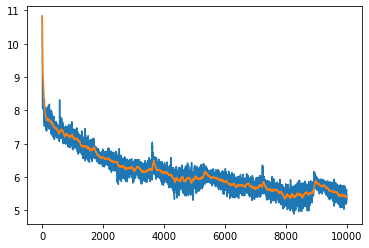

In [10]:
import numpy as np
import matplotlib.pyplot as plt

loss_list = loss_records[:10000]

loss_average = []
for i in range(len(loss_list)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if i < 50:
        avg_list = loss_list[:i+1]
    else:
        avg_list = loss_list[i-49:i+1]
    loss_average.append(np.average(avg_list))
plt.plot(loss_list)
plt.plot(loss_average)

## Generate Text (Simple RNN)

We will generate text with trained model.

> Note : Here I use greedy search. For drawbacks, see note in [this example](./05_language_model_basic.ipynb).

In [17]:
import numpy as np

def pred_output(sentence):
    test_seq = vectorization(sentence)
    test_seq = tf.expand_dims(test_seq, axis=1)

    vocab_list = vectorization.get_vocabulary()
    states = None
    print(vocab_list[tf.squeeze(test_seq[0]).numpy().tolist()], end=" ")
    for i in range(len(test_seq) - 1):
        y, states = model(
            tf.expand_dims(test_seq[i], axis=0),
            states=states,
            return_state=True)
        print(vocab_list[tf.squeeze(test_seq[i+1]).numpy().tolist()], end=" ")
    next_word_idx = tf.expand_dims(test_seq[len(test_seq) - 1], axis=0)
    while True:
        y, states = model(
            tf.convert_to_tensor(next_word_idx),
            states=states,
            return_state=True)
        next_word_idx = np.argmax(y, axis=2)
        if next_word_idx.item() == 0:
            break
        print(vocab_list[next_word_idx.item()], end=" ")
    print("\n")

pred_output("prime")
pred_output("chairman")
pred_output("He was expected")

prime minister najib razak has been appointed to the rubin graying sprayed the huffington post on the tarmac and the [UNK] of the [UNK] 

chairman of the union the researchers found that the [UNK] of the most exciting thing i was born in the past few weeks 

he was expected to be parked on the street style trotting with her heartbreaks and the most of the most beautiful 



## Train with GRU

Next we train the same with gated architecture, GRU (gated recurrent unit).<br>
As I have mentioned above, GRU layer has following architecture.

![gru architecture](images/gru_gate.png?raw=true)

$$ R : r_i = \sigma(W_{rx} x_i + W_{rs} s_{i-1}) $$
$$ Z : z_i = \sigma(W_{zx} x_i + W_{zs} s_{i-1}) $$

$$ \tilde{S} : \tilde{s}_i = tanh(W_{sx} x_i + W_{ss} (r_i \cdot s_{i-1})) $$
$$ S : s_i = (1 - z_i) \cdot s_{i-1} + z_i \cdot \tilde{s}_i $$

In this example, we use built-in layer ```tf.keras.layers.GRU``` in TensorFlow.

> Note : In the following example, we use bias term in GRU layer.

In [8]:
class GruLanguageModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size,
            embedding_dim,
            trainable=True,
        )
        self.gru = tf.keras.layers.GRU(
            rnn_units,
            use_bias=True,
            return_sequences=True,
            return_state=True,
            stateful=False,  # not to inherit states between batches
            trainable=True,
        )
        self.dense = tf.keras.layers.Dense(
            self.vocab_size,
            activation=None,
        )

    def call(self, inputs, states=None, training=False, return_state=False):
        tensor = self.embedding(inputs, training=training)
        if states is None:
            tensor, new_states = self.gru(tensor, training=training)
        else:
            tensor, new_states = self.gru(tensor, initial_state=states, training=training)
        outputs = self.dense(tensor, training=training)

        if return_state:
            return outputs, new_states  # This is used in prediction
        else:
            return outputs              # This is used in training

In [9]:
embedding_dim = 64
rnn_units = 512
n_epoch = 5
shuffle_buffer_size = 1000
train_seq_size = 50  # apply gradient (=train) in each 50 iterations
loss_records = []

model = GruLanguageModel(
    vocab_size=max_word,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
loss_func = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.SUM
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### I don't use train_tf_data.repeat(n_epoch) and run shuffle in each epoch,
### because I want to check result in each epoch
for epoch in range(n_epoch):
    tf_data_epoch = train_tf_data.shuffle(shuffle_buffer_size)
    iterator = iter(tf_data_epoch)

    loop_f = True
    while loop_f:
        input_count = 0
        losses = []
        with tf.GradientTape() as tape:
            for i in range(train_seq_size):
                try:
                    input_batch_x, input_batch_y = iterator.get_next()
                except tf.errors.OutOfRangeError:
                    loop_f = False
                    break
                batch_output = model(
                    tf.expand_dims(input_batch_x, axis=0),
                    training=True)
                loss = loss_func(
                    tf.expand_dims(input_batch_y, axis=0),
                    batch_output)
                losses.append(loss)
                input_count += len(input_batch_x)
            if input_count == 0:
                continue
            total_loss = tf.math.reduce_sum(losses)
            mean_loss = total_loss / input_count
        grad = tape.gradient(
            mean_loss,
            model.trainable_variables
        )
        opt.apply_gradients(zip(grad, model.trainable_variables))
        print("Epoch {}/{} - loss {loss:10.6f}".format(epoch+1, n_epoch, loss=mean_loss.numpy().tolist()), end="\r")
        loss_records.append(mean_loss.numpy().tolist())
    print("")

Epoch 1/5 - loss   6.879901
Epoch 2/5 - loss   5.829303
Epoch 3/5 - loss   5.815664
Epoch 4/5 - loss   4.926626
Epoch 5/5 - loss   4.143117


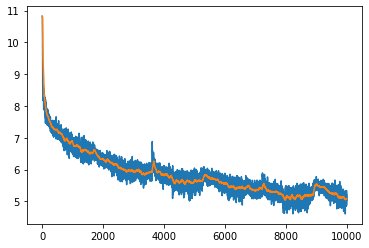

In [10]:
import numpy as np
import matplotlib.pyplot as plt

loss_list = loss_records[:10000]

loss_average = []
for i in range(len(loss_list)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if i < 50:
        avg_list = loss_list[:i+1]
    else:
        avg_list = loss_list[i-49:i+1]
    loss_average.append(np.average(avg_list))
plt.plot(loss_list)
plt.plot(loss_average)

# Generate Text (GRU)

> Note : Here I use greedy search. For drawbacks, see note in [this example](./05_language_model_basic.ipynb).

In [12]:
import numpy as np

def pred_output(sentence):
    test_seq = vectorization(sentence)
    test_seq = tf.expand_dims(test_seq, axis=1)

    vocab_list = vectorization.get_vocabulary()
    states = None
    print(vocab_list[tf.squeeze(test_seq[0]).numpy().tolist()], end=" ")
    for i in range(len(test_seq) - 1):
        y, states = model(
            tf.expand_dims(test_seq[i], axis=0),
            states=states,
            return_state=True)
        print(vocab_list[tf.squeeze(test_seq[i+1]).numpy().tolist()], end=" ")
    next_word_idx = tf.expand_dims(test_seq[len(test_seq) - 1], axis=0)
    while True:
        y, states = model(
            tf.convert_to_tensor(next_word_idx),
            states=states,
            return_state=True)
        next_word_idx = np.argmax(y, axis=2)
        if next_word_idx.item() == 0:
            break
        print(vocab_list[next_word_idx.item()], end=" ")
    print("\n")

pred_output("prime")
pred_output("chairman")
pred_output("He was expected")

prime minister najib razak is a baker of the [UNK] and the most powerful person in the world of the year of the year 

chairman of the huffington post on february 7th 2012 issue of the huffington post on february issue the issue of the new york times 

he was expected to announce the show on friday night on the show that he was spotted in the car and said he was 

